<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 31.0MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


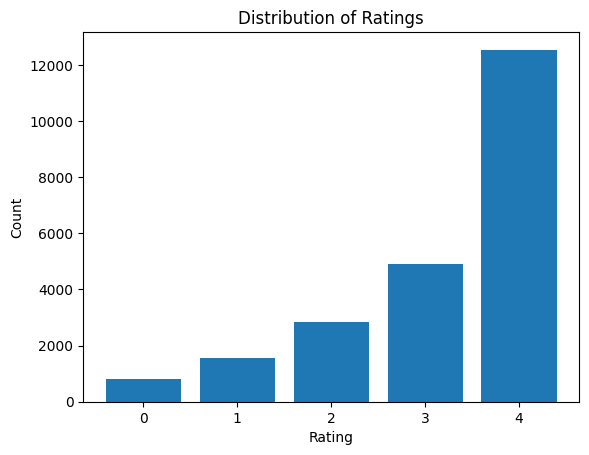

In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

rating_counts = df_reviews['Rating'].value_counts()
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()


In [7]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews = df_reviews['Review Text'].values

In [8]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
reviews.shape

(22641,)

In [9]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(reviews)
corpus

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# Alumno: ¿Cuál es la longitud de ese corpus?
corpus_length = len(corpus)
corpus_length

7011643

In [11]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)


In [12]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
print(tokens[0:20])

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']


In [13]:
# Alumno: ¿Cuántos tokens/palabras hay?
print("Cantidad de palabras ",len(tokens))

Cantidad de palabras  1372203


In [14]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(tokens)
vocab_size = num_words

In [15]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tokenizer.word_index
print(f"Cantidad total de palabras en el vocabulario: {len(word_index)}")

Cantidad total de palabras en el vocabulario: 14847


In [16]:
# Alumno: Convertir las palabras/tokens a números
sequences_indices = tokenizer.texts_to_sequences(reviews)
print(sequences_indices[0:5])

[[253, 532, 917, 3, 662, 3, 68], [21, 7, 18, 33, 1713, 99, 2, 1322, 8, 221, 5, 9, 4, 106, 3, 36, 314, 2, 131, 1243, 2, 429, 41, 24, 52, 5, 136, 1243, 33, 95, 2, 72, 4, 95, 3, 38, 501, 2, 21, 1, 86, 11, 31, 416, 39, 4, 53, 454, 1, 392, 41, 155, 29, 4, 130, 1372, 11, 438, 439, 6, 772, 95], [2, 65, 312, 178, 1095, 12, 7, 18, 3, 51, 195, 5, 8, 102, 12, 31, 2, 1152, 52, 1, 95, 46, 17, 236, 22, 10, 2, 219, 7, 8, 29, 46, 16, 46, 9, 661, 20, 2, 118, 19, 784, 5, 43, 2, 5, 9, 95, 97, 82, 15, 39, 637, 250, 1, 25, 656, 15, 68, 3, 26, 258, 10, 1, 175, 656, 65, 4, 23, 148, 272, 475, 3, 527, 718, 489, 151, 975, 1876, 4, 1877, 142, 1589, 15, 1, 151, 475, 830, 313, 1, 469, 5, 688], [2, 21, 21, 21, 7, 630, 33, 283, 1302, 3, 788, 316, 183, 2, 32, 5, 2, 115, 533, 10, 34, 210], [7, 80, 6, 23, 58, 8, 75, 486, 8, 1, 1157, 156, 467, 5, 6, 1, 54, 86, 8, 32, 14, 268, 3, 5, 6, 1190, 16, 5, 831, 59, 14, 251, 395, 21, 7, 80]]


In [17]:
# Alumno: Determinar cual es la oración más larga
max_length = max(len(s) for s in sequences_indices)
max_length

115

In [18]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
padded_sequences = pad_sequences(sequences_indices, maxlen=max_length)

In [19]:
# Alumno: Observar las dimensiones de la variable input
padded_sequences.shape

(22641, 115)

In [20]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = pd.get_dummies(df_reviews['Rating'])
y.shape

(22641, 5)

In [67]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
X_train.shape


(18112, 115)

In [23]:
# Alumno: determinar la dimensiones de entrada y salida


input_dim = X_train.shape[1]
print("Dimensión de entrada:", input_dim)

output_dim = y_train.shape[1]
print("Dimensión de salida:", output_dim)

Dimensión de entrada: 115
Dimensión de salida: 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [24]:
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download
From (redirected): https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download&confirm=t&uuid=b8be9b41-39f3-492f-acfe-f79a4a8fb9b4
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:52<00:00, 55.2MB/s]


In [25]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [26]:
model_fasttext = FasttextEmbeddings()

In [27]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [28]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout, Dense

model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length, trainable=False))
model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(rate=0.2))
model2.add(LSTM(units=64))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=5, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 300)          600000    
                                                                 
 lstm (LSTM)                 (None, 115, 64)           93440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [29]:
# Entrenar el modelo
history = model2.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.2)



Epoch 1/20
227/227 [==============================] - 14s 22ms/step - loss: 1.1648 - accuracy: 0.5655 - val_loss: 1.1089 - val_accuracy: 0.5622
Epoch 2/20
227/227 [==============================] - 3s 12ms/step - loss: 1.0377 - accuracy: 0.5874 - val_loss: 1.0518 - val_accuracy: 0.5716
Epoch 3/20
227/227 [==============================] - 3s 12ms/step - loss: 1.0019 - accuracy: 0.5983 - val_loss: 1.0577 - val_accuracy: 0.5727
Epoch 4/20
227/227 [==============================] - 3s 13ms/step - loss: 0.9687 - accuracy: 0.6037 - val_loss: 1.0046 - val_accuracy: 0.5799
Epoch 5/20
227/227 [==============================] - 3s 13ms/step - loss: 0.9524 - accuracy: 0.6092 - val_loss: 1.0232 - val_accuracy: 0.5747
Epoch 6/20
227/227 [==============================] - 3s 12ms/step - loss: 0.9346 - accuracy: 0.6173 - val_loss: 1.0077 - val_accuracy: 0.5857
Epoch 7/20
227/227 [==============================] - 3s 12ms/step - loss: 0.9249 - accuracy: 0.6219 - val_loss: 1.0176 - val_accuracy: 0.565

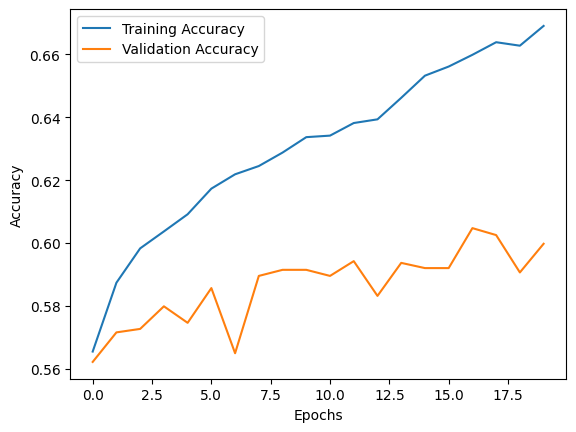

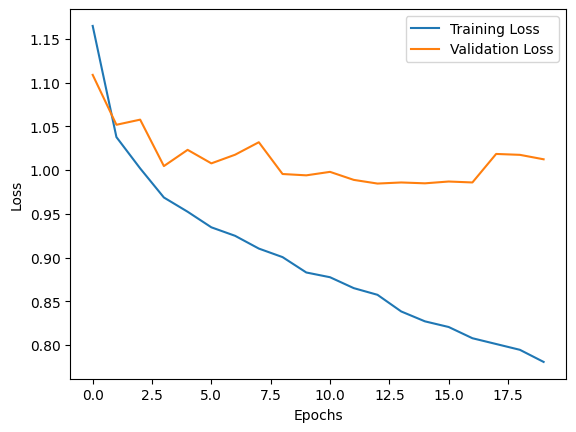

In [30]:
# Obtener la precisión y la pérdida del historial del entrenamiento
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficar la precisión
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Graficar la pérdida
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Entrenamiento sin Embedding pre-entrenados

In [31]:
# Crear el modelo
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length, trainable=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(output_dim, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Imprimir el resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_2 (LSTM)               (None, 115, 128)          219648    
                                                                 
 dropout_3 (Dropout)         (None, 115, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [32]:
history2 = model.fit(X_train, y_train, batch_size=64, epochs=30, validation_split=0.2)

Epoch 1/30
227/227 [==============================] - 42s 141ms/step - loss: 1.2940 - accuracy: 0.5299 - val_loss: 1.2514 - val_accuracy: 0.5402
Epoch 2/30
227/227 [==============================] - 10s 43ms/step - loss: 1.2332 - accuracy: 0.5570 - val_loss: 1.2481 - val_accuracy: 0.5402
Epoch 3/30
227/227 [==============================] - 8s 33ms/step - loss: 1.1649 - accuracy: 0.5575 - val_loss: 1.0740 - val_accuracy: 0.5575
Epoch 4/30
227/227 [==============================] - 6s 25ms/step - loss: 0.9400 - accuracy: 0.6152 - val_loss: 0.9467 - val_accuracy: 0.6034
Epoch 5/30
227/227 [==============================] - 5s 24ms/step - loss: 0.8694 - accuracy: 0.6389 - val_loss: 0.9542 - val_accuracy: 0.5998
Epoch 6/30
227/227 [==============================] - 6s 25ms/step - loss: 0.8298 - accuracy: 0.6508 - val_loss: 0.9473 - val_accuracy: 0.5954
Epoch 7/30
227/227 [==============================] - 5s 20ms/step - loss: 0.9014 - accuracy: 0.6269 - val_loss: 0.9621 - val_accuracy: 0.5

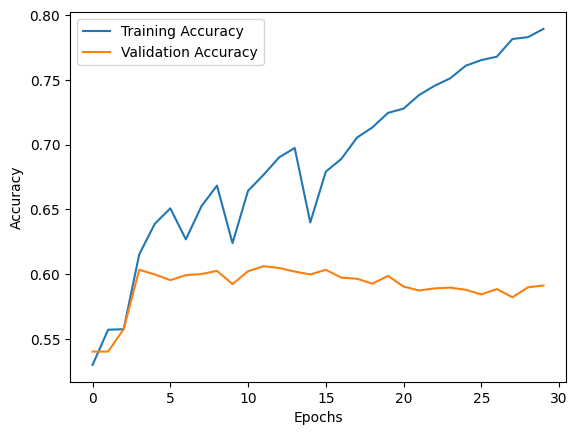

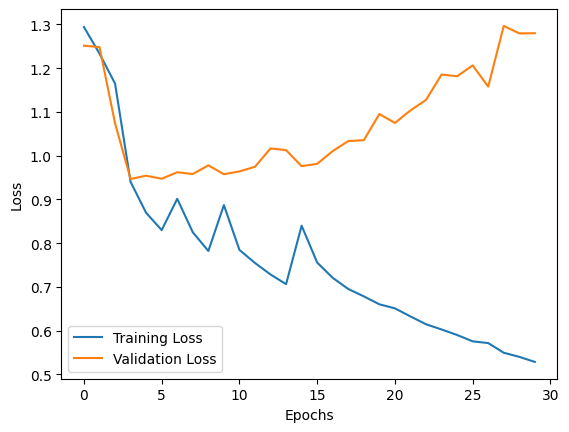

In [33]:
# Obtener la precisión y la pérdida del historial del entrenamiento
train_accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

# Graficar la precisión
plt.plot(train_accuracy2, label='Training Accuracy')
plt.plot(val_accuracy2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Graficar la pérdida
plt.plot(train_loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

142/142 [==============================] - 1s 5ms/step


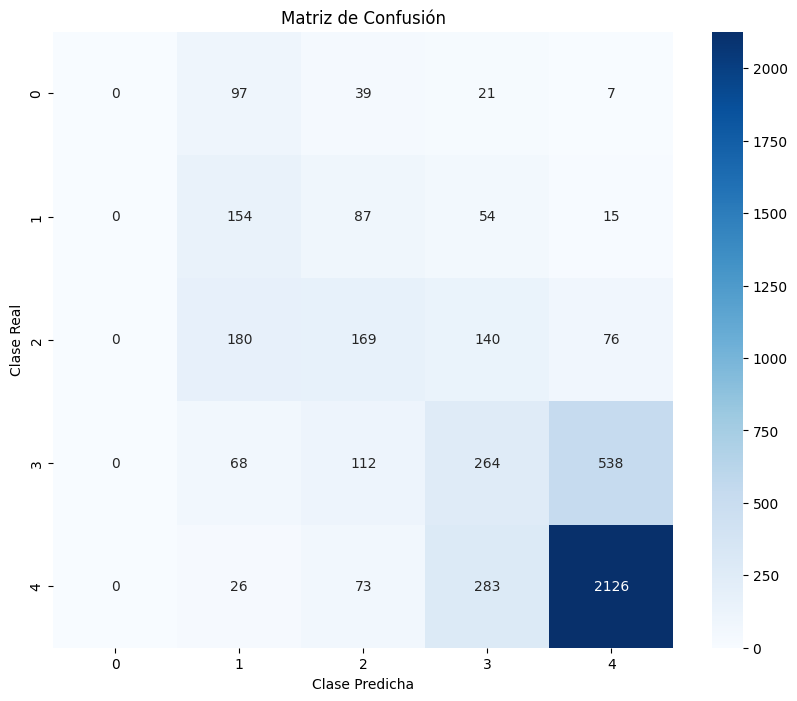

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las predicciones del conjunto de prueba
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_max = np.argmax(y_test.values, axis=1)

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_test_max, y_pred)

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Clase Predicha")
plt.ylabel("Clase Real")
plt.show()



In [71]:
from sklearn.metrics import precision_score, recall_score, f1_score


precision = precision_score(y_test_max, y_pred, average='weighted')
recall = recall_score(y_test_max, y_pred, average='weighted')
f1 = f1_score(y_test_max, y_pred, average='weighted')

print("Precisión:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precisión: 0.5653718130368172
Recall: 0.599028483108854
F1-score: 0.5780368551521063


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


142/142 [==============================] - 1s 5ms/step


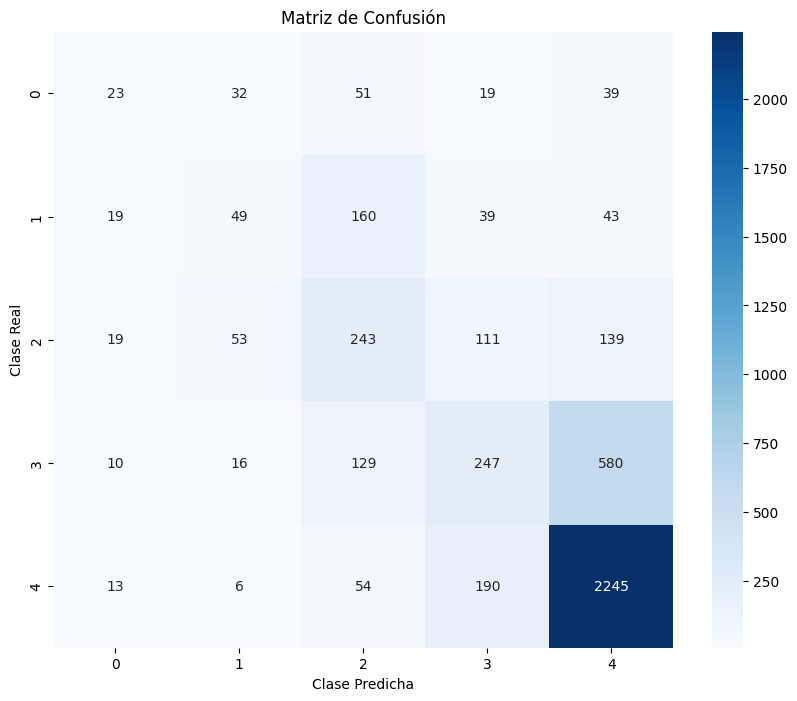

In [72]:
# Obtener las predicciones del conjunto de prueba
y_pred2 = model2.predict(X_test)
y_pred2 = np.argmax(y_pred2, axis=1)
y_test_max2 = np.argmax(y_test.values, axis=1)

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_test_max2, y_pred2)

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Clase Predicha")
plt.ylabel("Clase Real")
plt.show()



In [74]:

precision = precision_score(y_test_max2, y_pred2, average='weighted')
recall = recall_score(y_test_max2, y_pred2, average='weighted')

print("Precisión:", precision)
print("Recall:", recall)
f1 = f1_score(y_test_max2, y_pred, average='weighted')

print("F1-score:", f1)

Precisión: 0.575522438704654
Recall: 0.6197836166924265
F1-score: 0.5780368551521063


#Conclusión

- el modelo con fastext dio menos overfitting con respecto al modelo con embedding sin entrenar, por lo que para este último toca realizar un ajuste de hiperparametros más complejo
- Ambos modelos en la cantidad de épocas no presentan grandes diferencias en las demás métricas diferentes a accuracy
